# Реалізація методики системного аналізу в Jupyter

В документі об'єднуються деякі методи [системного аналізу](https://uk.wikipedia.org/wiki/Системний_аналіз) для розв'язування проблеми, що слабо формалізується:
1. [Ментальні карти (Mind map)](https://uk.wikipedia.org/wiki/Мапа_думок) для ефективного мозкового штурму
2. [Морфологічний аналіз](https://uk.wikipedia.org/wiki/Морфологічний_аналіз_(винахідництво))
3. [Експертне оцінювання](https://ru.wikipedia.org/wiki/Экспертное_оценивание)
4. Візуалізація [графів](https://uk.wikipedia.org/wiki/Граф_(математика)) експертного оцінювання
5. [Алгоритми на графах](https://en.wikipedia.org/wiki/Category:Graph_algorithms)
6. [Кластерний аналіз](https://uk.wikipedia.org/wiki/Кластерний_аналіз)
7. Модель [класифікації](https://uk.wikipedia.org/wiki/Бінарна_класифікація) машинного навчання

Користувач може доповнити ці методи іншими, які реалізовані в різноманітних пакетах Python. Зокрема це методи аналітичного та чисельного моделювання, розв'язування рівнянь та оптимізації, статистичного моделювання, комбінаторні алгоритми, логічне програмування та інші.
Методи СА поділяють на дві групи: методи активізації інтуїції спеціалістів (МАІС) та методи формалізованого подання системи (МФПС). Методи повинні застосовуватись в раціональній послідовності. Зокрема методи МАІС повинні чергуватись з методами МФПС. Застосування цих методів являє собою ітераційний процес з можливим поверненням на попередні етапи, зміною методів та їхньої послідовності. З кожною ітерацією відбувається покращення якості моделі прийняття рішення.

## Ментальні карти
Для візуалізації ментальної карти використовується сервіс mermaid.ink та функція displayMermaid(graph), де graph - рядок з кодом діаграми Mermaid. Діаграми типу mindmap описуються шляхом ієрархічного переліку концептів, який утворюється за допомогою відступів. Під час мозкового штурму вводьте концепції в цей перелік і запускайте код комірки для візуалізації.

In [4]:
import base64
from IPython.display import Image, display
import matplotlib.pyplot as plt

def displayMermaid(graph):
    graphbytes = graph.encode("utf8")
    base64_bytes = base64.b64encode(graphbytes)
    base64_string = base64_bytes.decode("ascii")
    display(Image(url="https://mermaid.ink/img/" + base64_string))

graph="""
mindmap
Root
    A
      B
      C
"""
displayMermaid(graph)

## Морфологічний аналіз
Вибираємо наступним методом метод морфологічного аналізу, так як його слід відносити до іншого класу (МФПС). Для автоматизації передачі результатів від попереднього методу створено функції parse_hierarchy (повертає ієрархію у вигляді списку) та parse_simple (повертає список усіх концептів без ієрархії). Для прикладу застосуємо parse_simple та отримаємо множину ісіх концептів S. Передамо її itertools.combinations для отримання усіх комбінації з двох елементів - морфологічної матриці. Перегляд цієї матриці дозволить звернути увагу на перспективні комбінації.

In [5]:
def parse_hierarchy(lines, level=0):
    while lines:
        line = lines[0]
        indent = len(line) - len(line.lstrip(' '))
        if indent == level:  # the line is at the current level
            yield line.lstrip()
            lines.pop(0)
        elif indent > level:  # the line is at a deeper level
            yield list(parse_hierarchy(lines, level=indent))
        else:  # the line is at a higher level
            return  # end recursion

list(parse_hierarchy(graph.splitlines()[2:], level=0))

['Root', ['A', ['B', 'C']]]

In [6]:
def parse_simple(lines):
    for line in lines:
        yield line.lstrip() 
        
S=set(parse_simple(graph.splitlines()[2:]))

import itertools    
list(itertools.combinations(S,2))

[('A', 'C'),
 ('A', 'B'),
 ('A', 'Root'),
 ('C', 'B'),
 ('C', 'Root'),
 ('B', 'Root')]

## Експертне оцінювання та його візуалізація
Експертне оцінювання належить до МАІС та полягає в передачі цієї матриці експертам з проханням оцінити кожну комбінацію за шкалою від 0 до 1. Один експерт може також поставити кілька оцінок за різними критеріями. В результаті отримуємо словник G. Функція graph2mermaid будує граф за цією структурою. Побудований нижче граф містить тільки перші оцінки. Спробуйте також отримати граф з середніми оцінками.

In [7]:
G={('B', 'Root'):(0.1,0.2),
 ('B', 'A'):(0.2,0.1),
 ('B', 'C'):(0.9,0.8),
 ('Root', 'A'):(1.0,1.0),
 ('Root', 'C'):(0.1,0.0),
 ('A', 'C'):(0.0,0.0)}

def graph2mermaid(G, properties=[]):
    tmp="""
graph TD;
%s
"""
    edges=""
    for s,o in G:
        #print(s,p,o)
        p=G[(s,o)][0]
        #if p not in properties: continue
        edges+="    "+s+"-- "+str(p)+" ---"+o+";\n"
    if not edges: return
    return tmp%edges
    
displayMermaid(graph2mermaid(G, properties=[0,1]))

## Алгоритми на графах
Для аналізу графів застосуємо алгоритми на графах (МФПС). Зокрема алгоритм [PageRank](https://uk.wikipedia.org/wiki/PageRank) дозволяє ідентифікувати найбільш авторитетні вузли. Увага! Це алгоритм для спрямованих графів. Замість комбінацій застосовуйте перестановки. Спробуйте також інші алгоритми.

In [9]:
%pip install -q scipy

In [10]:
import networkx as nx
Gr=nx.DiGraph()
Gr.add_weighted_edges_from([(s, o, G[(s,o)][0]) for s,o in G])
nx.pagerank(Gr, alpha=0.9)

{'B': 0.17043062943603157,
 'Root': 0.18321285094459652,
 'A': 0.3458958216832472,
 'C': 0.30046069793612473}

## Кластеризація експертних оцінок
Кластеризація (МФПС) дозволяє автоматично знайти групи (кластери) експертних оцінок. Графік показує дві групи оцінок - низькі і високі. Далі слід зосередитись на комбінаціях в групі високих оцінок.

/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/lib/python3.11/site-packages/threadpoolctl.py:1019: RuntimeWarning: libc not found. The ctypes module in Python 3.11 is maybe too old for this OS.
  warnings.warn(


[[0.1 0.2]
 [0.2 0.1]
 [0.9 0.8]
 [1.  1. ]
 [0.1 0. ]
 [0.  0. ]]
[0 0 1 1 0 0]
[0]
[[0.1   0.075]
 [0.95  0.9  ]]


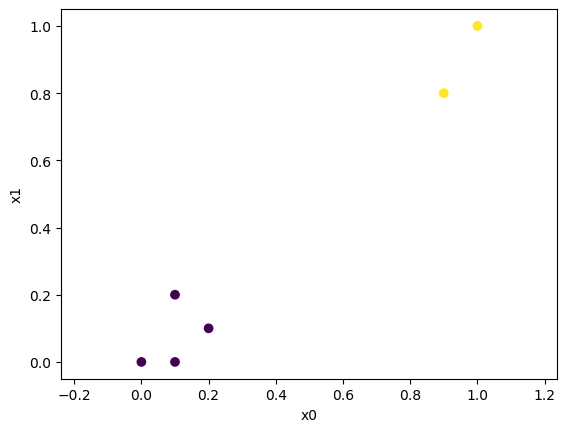

In [11]:
import numpy as np
import matplotlib.pyplot as plt
plt.axis('equal')
from sklearn.cluster import KMeans

# дані - дві ознаки класів
x=np.array([[x0, x1] for x0,x1 in G.values()])
m=KMeans(n_clusters=2) # метод k-середніх
# алгоритм обчислює центри ваги кластерів
m.fit(x)
y=m.labels_ # мітки класів
print(x)
print(y)
print(m.predict([[0.5,0.5]])) # прогноз в новій точці
print(m.cluster_centers_) # центри кластерів

plt.scatter(x[:,0], x[:,1], c=y) # візуалізація класів
plt.xlabel('x0'), plt.ylabel('x1')
plt.show()

## Класифікація експертного оцінювання (1)
Класифікація експерних оцінок (МФПС) дозволить прогнозувати клас y оцінок за ознаками x. Ознаками x можуть бути концепти A,B,C, їхні комбінації, оцінки за іншими критеріями та інше.

In [35]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
lb = LabelBinarizer()
x=[]
xo=[]
for k,v in G.items():
    x.append(str(k))
    xo.append(v[0])
for k,v in G.items():
    x.append(str(k))
    xo.append(v[1])
print(x)
x=lb.fit_transform(x)
x=np.hstack([x, np.array(xo).reshape(-1,1)])
y=[0,0,1,1,0,0,0,0,1,1,0,0]
model=LogisticRegression()
model.fit(x,y)
xp=lb.transform(["('Root', 'C')"])
print(xp)
print(np.hstack([x, np.array(y).reshape(-1,1)])) # x,y
print(model.predict([[0,  0,  0,  0,  0,  1,  0.5]])) # прогноз

["('B', 'Root')", "('B', 'A')", "('B', 'C')", "('Root', 'A')", "('Root', 'C')", "('A', 'C')", "('B', 'Root')", "('B', 'A')", "('B', 'C')", "('Root', 'A')", "('Root', 'C')", "('A', 'C')"]
[[0 0 0 0 0 1]]
[[0.  0.  0.  1.  0.  0.  0.1 0. ]
 [0.  1.  0.  0.  0.  0.  0.2 0. ]
 [0.  0.  1.  0.  0.  0.  0.9 1. ]
 [0.  0.  0.  0.  1.  0.  1.  1. ]
 [0.  0.  0.  0.  0.  1.  0.1 0. ]
 [1.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  1.  0.  0.  0.2 0. ]
 [0.  1.  0.  0.  0.  0.  0.1 0. ]
 [0.  0.  1.  0.  0.  0.  0.8 1. ]
 [0.  0.  0.  0.  1.  0.  1.  1. ]
 [0.  0.  0.  0.  0.  1.  0.  0. ]
 [1.  0.  0.  0.  0.  0.  0.  0. ]]
[0]


## Класифікація експертного оцінювання (2)
Ще один спосіб класифікації. Тут є три ознаки x - кількість концептів A, B, C в прийнятому рішенні. Клас y - це показник якості. x та y визначаються шляхом експертного оцінювання або іншим способом (моделювання, експеримент, моніторинг і т.п.)

In [28]:
x=np.array([[0,1,1,2,2,3,2,3,1,3, 6,5,6,7,7,8,7,7,8,5],  #A
            [0,1,1,2,2,3,2,3,1,3, 6,5,6,7,7,8,7,7,8,5],  #B
            [1,1,3,1,2,2,3,4,4,1, 5,7,6,7,6,7,5,8,8,8]]) #C 
y=np.array( [0,0,0,0,0,0,0,0,0,0, 1,1,1,1,1,1,1,1,1,1] ) #Quality
x=x.T
model=LogisticRegression()
model.fit(x,y)
model.predict([[5,5,5]])
plt.scatter(x[:,0], x[:,1], c=y) # візуалізація класів
plt.xlabel('x0'), plt.ylabel('x1')
plt.show()

array([1])

## Інші методи
Для застосування інших методів установіть відповідні пакети Python або запрограмуйте відповідні процедури. Приклад установлення пакета:

In [5]:
%pip install -q python-constraint